# Introduction to GeoPandas
[intro](https://geopandas.org/en/stable/getting_started/introduction.html)

In [1]:
import geopandas

path_to_data = geopandas.datasets.get_path("nybb")
gdf = geopandas.read_file(path_to_data)

gdf

BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry  
0  MULTIPOLYGON (((970217.022 145643.332, 970227....  
1  MULTIPOLYGON (((1029606.077 156073.814, 102957...  
2  MULTIPOLYGON (((1021176.479 151374.797, 102100...  
3  MULTIPOLYGON (((981219.056 188655.316, 980940....  
4  MULTIPOLYGON (((1012821.806 229228.265, 101278...

## Writing files

To write a GeoDataFrame back to file use GeoDataFrame.to_file(). The default file format is Shapefile, but you can specify your own with the driver keyword.

In [2]:
gdf.to_file("my_file.geojson", driver="GeoJSON")

## Measuring area in square km

To measure the area of each polygon (or MultiPolygon in this specific case), access the GeoDataFrame.area attribute, which returns a pandas.Series. Note that GeoDataFrame.area is just GeoSeries.area applied to the active geometry column.

But first, to make the results easier to read, set the names of the boroughs as the index:

In [3]:
gdf = gdf.set_index("BoroName")
gdf["area"] = gdf.area/1e6
gdf["area"]

BoroName
Staten Island    1623.821997
Queens           3045.213694
Brooklyn         1937.478349
Manhattan         636.471238
Bronx            1186.926294
Name: area, dtype: float64

## Getting polygon boundary and centroid

To get the boundary of each polygon (LineString), access the GeoDataFrame.boundary:

In [4]:
gdf['boundary'] = gdf.boundary
gdf['boundary']

BoroName
Staten Island    MULTILINESTRING ((970217.022 145643.332, 97022...
Queens           MULTILINESTRING ((1029606.077 156073.814, 1029...
Brooklyn         MULTILINESTRING ((1021176.479 151374.797, 1021...
Manhattan        MULTILINESTRING ((981219.056 188655.316, 98094...
Bronx            MULTILINESTRING ((1012821.806 229228.265, 1012...
Name: boundary, dtype: geometry

Since we have saved boundary as a new column, we now have two geometry columns in the same GeoDataFrame.

We can also create new geometries, which could be, for example, a buffered version of the original one (i.e., GeoDataFrame.buffer(10)) or its centroid:

In [5]:
gdf['centroid'] = gdf.centroid
gdf['centroid']

BoroName
Staten Island     POINT (941639.450 150931.991)
Queens           POINT (1034578.078 197116.604)
Brooklyn          POINT (998769.115 174169.761)
Manhattan         POINT (993336.965 222451.437)
Bronx            POINT (1021174.790 249937.980)
Name: centroid, dtype: geometry

## Measuring distance

We can also measure how far each centroid is from the first centroid location.

In [6]:
first_point = gdf['centroid'].iloc[0]
gdf['distance'] = gdf['centroid'].distance(first_point)
gdf['distance']

BoroName
Staten Island         0.000000
Queens           103781.535276
Brooklyn          61674.893421
Manhattan         88247.742789
Bronx            126996.283623
Name: distance, dtype: float64

Note that geopandas.GeoDataFrame is a subclass of pandas.DataFrame, so we have all the pandas functionality available to use on the geospatial dataset — we can even perform data manipulations with the attributes and geometry information together.

For example, to calculate the average of the distances measured above, access the ‘distance’ column and call the mean() method on it:

In [7]:
gdf['distance'].mean()

76140.09102166798

## Making maps

GeoPandas can also plot maps, so we can check how the geometries appear in space. To plot the active geometry, call GeoDataFrame.plot(). To color code by another column, pass in that column as the first argument. In the example below, we plot the active geometry column and color code by the "area" column. We also want to show a legend (legend=True).

<AxesSubplot: >

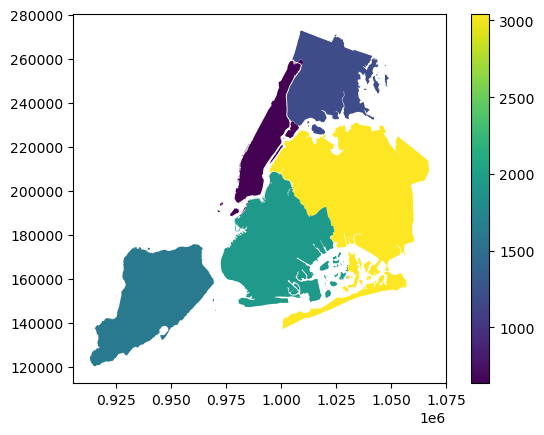

In [8]:
gdf.plot("area", legend=True)

You can also explore your data interactively using GeoDataFrame.explore(), which behaves in the same way plot() does but returns an interactive map instead.

In [25]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [9]:
gdf.explore("area", legend=False)

Make this Notebook Trusted to load map: File -> Trust Notebook
Switching the active geometry (GeoDataFrame.set_geometry) to centroids, we can plot the same data using point geometry.

<AxesSubplot: >

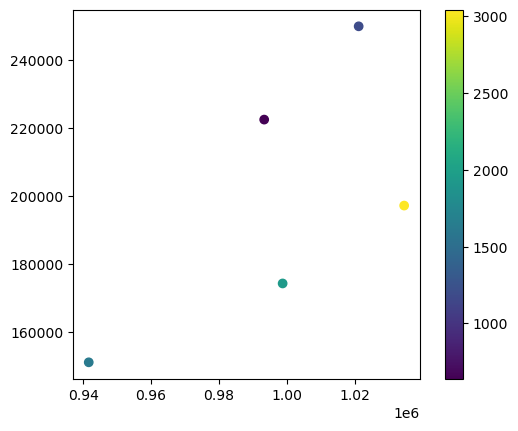

In [10]:
gdf = gdf.set_geometry("centroid")
gdf.plot("area", legend=True)

And we can also layer both GeoSeries on top of each other. We just need to use one plot as an axis for the other.

<AxesSubplot: >

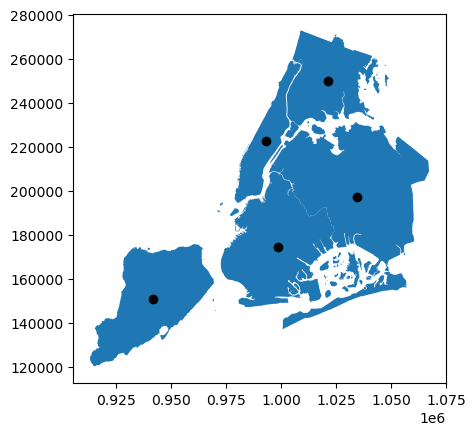

In [11]:
ax = gdf["geometry"].plot()
gdf["centroid"].plot(ax=ax, color="black")

Now we set the active geometry back to the original GeoSeries.

In [12]:
gdf = gdf.set_geometry("geometry")

## Geometry creation
We can further work with the geometry and create new shapes based on those we already have.

### Convex hull
If we are interested in the convex hull of our polygons, we can access GeoDataFrame.convex_hull.


In [13]:
gdf["convex_hull"] = gdf.convex_hull

<AxesSubplot: >

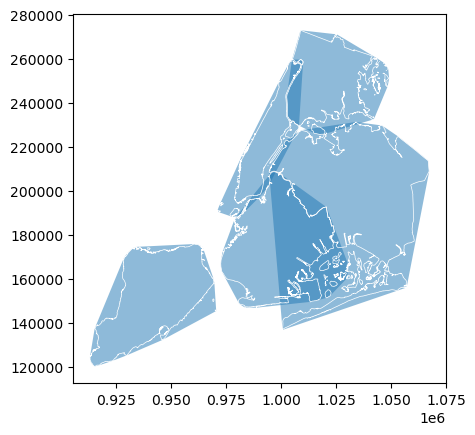

In [14]:
ax = gdf["convex_hull"].plot(alpha=.5)  # saving the first plot as an axis and setting alpha (transparency) to 0.5
gdf["boundary"].plot(ax=ax, color="white", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

## Buffer

In other cases, we may need to buffer the geometry using GeoDataFrame.buffer(). Geometry methods are automatically applied to the active geometry, but we can apply them directly to any GeoSeries as well. Let’s buffer the boroughs and their centroids and plot both on top of each other.

<AxesSubplot: >

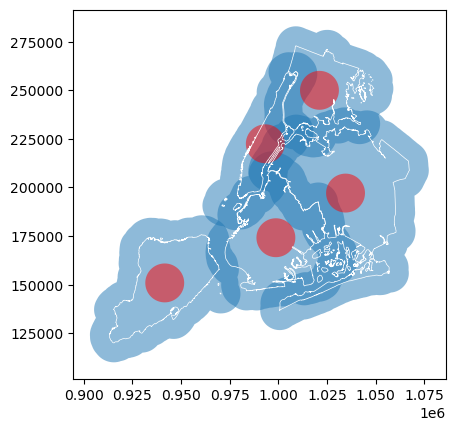

In [15]:
# buffering the active geometry by 10 000 feet (geometry is already in feet)
gdf["buffered"] = gdf.buffer(10000)

# buffering the centroid geometry by 10 000 feet (geometry is already in feet)
gdf["buffered_centroid"] = gdf["centroid"].buffer(10000)
ax = gdf["buffered"].plot(alpha=.5)  # saving the first plot as an axis and setting alpha (transparency) to 0.5
gdf["buffered_centroid"].plot(ax=ax, color="red", alpha=.5)  # passing the first plot as an axis to the second
gdf["boundary"].plot(ax=ax, color="white", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

## Geometry relations

We can also ask about the spatial relations of different geometries. Using the geometries above, we can check which of the buffered boroughs intersect the original geometry of Brooklyn, i.e., is within 10 000 feet from Brooklyn.

First, we get a polygon of Brooklyn.


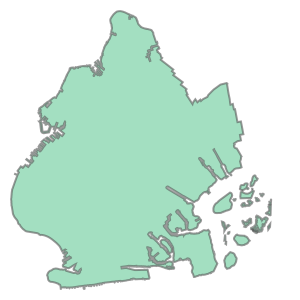

In [16]:
brooklyn = gdf.loc["Brooklyn", "geometry"]
brooklyn

The polygon is a shapely geometry object, as any other geometry used in GeoPandas.

In [17]:
type(brooklyn)

shapely.geometry.multipolygon.MultiPolygon

Then we can check which of the geometries in gdf["buffered"] intersects it.

In [18]:
gdf["buffered"].intersects(brooklyn)

BoroName
Staten Island     True
Queens            True
Brooklyn          True
Manhattan         True
Bronx            False
dtype: bool

Only Bronx (on the north) is more than 10 000 feet away from Brooklyn. All the others are closer and intersect our polygon.

Alternatively, we can check which buffered centroids are entirely within the original boroughs polygons. In this case, both GeoSeries are aligned, and the check is performed for each row.

In [19]:
gdf["within"] = gdf["buffered_centroid"].within(gdf)
gdf["within"]

BoroName
Staten Island     True
Queens            True
Brooklyn         False
Manhattan        False
Bronx            False
Name: within, dtype: bool

We can plot the results on the map to confirm the finding.

<AxesSubplot: >

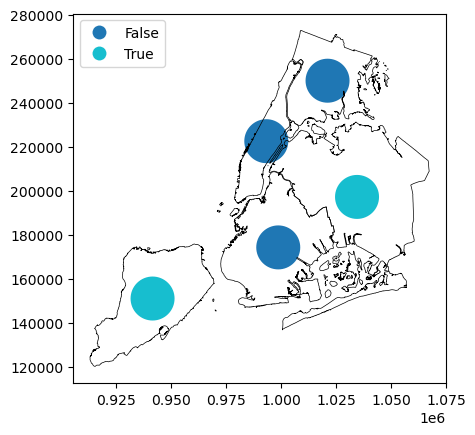

In [20]:
gdf = gdf.set_geometry("buffered_centroid")
ax = gdf.plot("within", legend=True, categorical=True, legend_kwds={'loc': "upper left"})  # using categorical plot and setting the position of the legend
gdf["boundary"].plot(ax=ax, color="black", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

## Projections

Each GeoSeries has its Coordinate Reference System (CRS) accessible at GeoSeries.crs. The CRS tells GeoPandas where the coordinates of the geometries are located on the earth’s surface. In some cases, the CRS is geographic, which means that the coordinates are in latitude and longitude. In those cases, its CRS is WGS84, with the authority code EPSG:4326. Let’s see the projection of our NY boroughs GeoDataFrame.


In [21]:
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Geometries are in EPSG:2263 with coordinates in feet. We can easily re-project a GeoSeries to another CRS, like EPSG:4326 using GeoSeries.to_crs().

<AxesSubplot: >

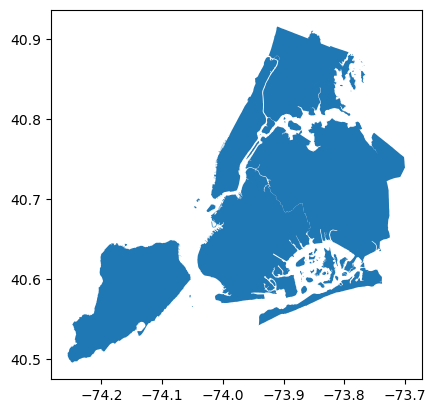

In [22]:
gdf = gdf.set_geometry("geometry")
boroughs_4326 = gdf.to_crs("EPSG:4326")
boroughs_4326.plot()

In [23]:
boroughs_4326.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Notice the difference in coordinates along the axes of the plot. Where we had 120 000 - 280 000 (feet) before, we now have 40.5 - 40.9 (degrees). In this case, boroughs_4326 has a "geometry" column in WGS84 but all the other (with centroids etc.) remain in the original CRS.